In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler

import pandas as pd
from torch import nn, optim

from sklearn.metrics import confusion_matrix

In [2]:
#from ConvNet import ConvNet

In [3]:
class_names = ('N', 'A', 'L', 'R', 'V')

In [4]:
train_pth = 'sh_dataset\\train\\'

val_pth = 'sh_dataset\\validation\\'

MODEL_PATH = 'models\\model.pth'

model_name = 'small_model'

DIR = 'models\\small_model\\'

In [5]:
class DatasetECG(torch.utils.data.Dataset):
    def __init__(self, path_dir:str):
        super().__init__()
        
        self.path_dir = path_dir
        
        self.dir_list = sorted(os.listdir(path_dir))        

        print(len(self.dir_list))

        
    def __len__(self):
        return len(self.dir_list)
    
    def __getitem__(self, idx):

        class_id = self.dir_list[idx][0] 

        if class_id == 'N':
            class_id = 0
            img_path = os.path.join(self.path_dir, self.dir_list[idx])

        elif class_id == 'A':
            class_id = 1
            img_path = os.path.join(self.path_dir, self.dir_list[idx])

        elif class_id == 'L':
            class_id = 2
            img_path = os.path.join(self.path_dir, self.dir_list[idx])
        
        elif class_id == 'R':
            class_id = 3
            img_path = os.path.join(self.path_dir, self.dir_list[idx])

        elif class_id == 'V':
            class_id = 4
            img_path = os.path.join(self.path_dir, self.dir_list[idx])
        
        img = np.load(img_path)

        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
        return t_img, t_class_id

In [6]:
train_ds_ecg = DatasetECG(train_pth)
val_ds_ecg = DatasetECG(val_pth)

7500
1250


In [7]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_ds_ecg, shuffle=True, 
    batch_size=batch_size, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds_ecg, shuffle=True,
    batch_size=batch_size, drop_last=True
)

print(len(train_loader), len(val_loader))

468 78


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
#        self.act = nn.ReLU()
#        self.maxpool = nn.MaxPool2d(2, 2)
#        self.conv0 = nn.Conv2d(1, 16, 5, stride=1, padding=0)#1 16 3
#        self.conv1 = nn.Conv2d(16, 32, 5, stride=1, padding=0)#16 32 3
#        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
#        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
#
#        #self.linear0 = nn.Linear(128*12*12, 512)
#        self.linear0 = nn.Linear(128*11*11, 512)        
#        self.linear1 = nn.Linear(512, 128)
#        self.linear2 = nn.Linear(128, 5)

        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv0 = nn.Conv2d(1, 2, 5, stride=1, padding=0)#1 16 3
        self.conv1 = nn.Conv2d(2, 4, 5, stride=1, padding=0)#16 32 3
        self.conv2 = nn.Conv2d(4, 7, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(7, 13, 3, stride=1, padding=0)

        self.linear0 = nn.Linear(1573, 52)        
        self.linear1 = nn.Linear(52, 13)
        self.linear2 = nn.Linear(13, 5)
        
        
    def forward(self, x):
#        print(x.shape)
        out = self.conv0(x)
        out = self.act(out)
#        print(out.shape)
        out = self.maxpool(out)
#        print(out.shape)
        out = self.conv1(out)
        out = self.act(out)
#        print(out.shape)
        out = self.maxpool(out)
#        print(out.shape)
        out = self.conv2(out)
        out = self.act(out)
#        print(out.shape)
        out = self.maxpool(out)
#        print(out.shape)
        out = self.conv3(out)
#        print(out.shape)
        out = self.act(out)
#        print(out.shape) 
        out = torch.flatten(out, 1)
#        print(out.shape) 
        out = self.linear0(out)
        out = self.act(out)
#        print(out.shape) 
        out = self.linear1(out)
        out = self.act(out)
#        print(out.shape) 
        out = self.linear2(out)
#        print(out.shape) 
        return out

In [9]:
model = ConvNet()
model

ConvNet(
  (act): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv1): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 7, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(7, 13, kernel_size=(3, 3), stride=(1, 1))
  (linear0): Linear(in_features=1573, out_features=52, bias=True)
  (linear1): Linear(in_features=52, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=5, bias=True)
)

In [10]:
#model = torch.load(MODEL_PATH)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

83954

In [12]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

epochs = 6

In [13]:
device = 'cuda' # if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = loss_fn.to(device)

use_amp = True
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

print(device)

cuda


In [14]:
train_losses=[]
train_accu=[]

eval_losses=[]
eval_accu=[]

In [15]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(train_loader):
    inputs = data[0].to(device, non_blocking=True)
    labels=data[1].to(device, non_blocking=True)

    outputs=model(inputs)

    loss=loss_fn(outputs,labels)

    #Replaces pow(2.0) with abs() for L1 regularization

    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

      
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [16]:
def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():

    for data in tqdm(val_loader):
      images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)

      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()


  test_loss=running_loss/len(val_loader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)
  
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

  #return accu

In [17]:
max_accuracy = 0

for epoch in range(1,epochs+1): 
  D_MOD_PTH = DIR + 'd_' + model_name  + str(epoch) + '.pth'
  MOD_PTH = DIR + model_name + str(epoch) + '.pth'
  train(epoch)
  test(epoch)
  acc_ep = eval_accu[-1]

  if acc_ep > max_accuracy:
    max_accuracy = acc_ep    
    torch.save(model, MOD_PTH)
    torch.save(model.state_dict(), D_MOD_PTH)



Epoch : 1


100%|██████████| 468/468 [00:12<00:00, 38.60it/s]


Train Loss: 1.643 | Accuracy: 22.329


100%|██████████| 78/78 [00:00<00:00, 87.95it/s]


Test Loss: 1.585 | Accuracy: 37.500

Epoch : 2


100%|██████████| 468/468 [00:08<00:00, 55.13it/s]


Train Loss: 0.816 | Accuracy: 73.918


100%|██████████| 78/78 [00:00<00:00, 78.42it/s]


Test Loss: 0.320 | Accuracy: 91.506

Epoch : 3


100%|██████████| 468/468 [00:08<00:00, 57.52it/s]


Train Loss: 0.238 | Accuracy: 93.670


100%|██████████| 78/78 [00:00<00:00, 86.20it/s]


Test Loss: 0.158 | Accuracy: 95.272

Epoch : 4


100%|██████████| 468/468 [00:08<00:00, 57.62it/s]


Train Loss: 0.159 | Accuracy: 96.488


100%|██████████| 78/78 [00:01<00:00, 68.46it/s]


Test Loss: 0.104 | Accuracy: 96.715

Epoch : 5


100%|██████████| 468/468 [00:07<00:00, 59.42it/s]


Train Loss: 0.128 | Accuracy: 97.409


100%|██████████| 78/78 [00:01<00:00, 67.21it/s]


Test Loss: 0.108 | Accuracy: 97.436

Epoch : 6


100%|██████████| 468/468 [00:07<00:00, 64.00it/s]


Train Loss: 0.109 | Accuracy: 98.024


100%|██████████| 78/78 [00:00<00:00, 103.31it/s]

Test Loss: 0.090 | Accuracy: 97.676


In [18]:
np.save(DIR + model_name + '_train_losses', train_losses)
np.save(DIR + model_name + '_eval_losses', eval_losses)
np.save(DIR + model_name + '_train_accu', train_accu)
np.save(DIR + model_name + '_eval_accu', eval_accu)

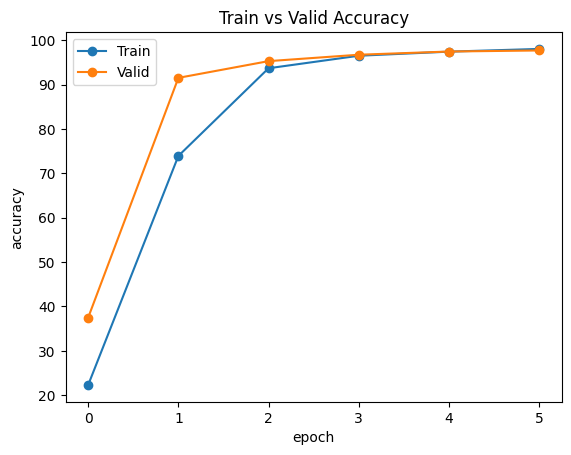

In [19]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

In [23]:
eval_accu

[37.5,
 91.50641025641026,
 95.2724358974359,
 96.71474358974359,
 97.43589743589743,
 97.67628205128206]

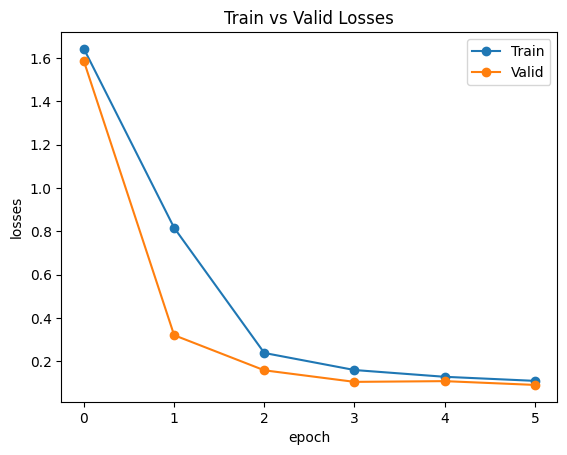

In [20]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [21]:
torch.save(model, MODEL_PATH)
torch.save(model.state_dict(), MODEL_PATH)

In [22]:
#torch.save(model.state_dict(), 'd_' + MODEL_PATH)
#model.load_state_dict(torch.load('d_' + MODEL_PATH))